In [ ]:
import warnings
import sys
import os

warnings.filterwarnings("ignore")

In [241]:
# need to be able to import src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# absolute path to the src directory
src_path = os.path.abspath("../src")

# Add src directory to system path
sys.path.append(src_path)

# get the /MLCBAss1/Assignment-1 path
ass_path=sys.path[-2]

print(ass_path)

f:\Vital Stuff\Εργασίες Σχολείου\The dreadful present\Μαστερ\Μαστερ Εξάμηνο 2ο\Machine Learning in Computational Biology\Project\FinalProject\MLKinCompBioFinalProject


In [242]:
%load_ext autoreload
%autoreload 2

from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
adata_hyv2= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_hyv2)

print("\n\n-----Obs header-----\n\n",adata_hyv2.obs.head())
print("\n\n-----Var header-----\n\n",adata_hyv2.var.head())

AnnData object with n_obs × n_vars = 100562 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
AACGTTGAGGCTAGCA-063_E01  AACGTTGAGGCTAGCA  L8TX_181031_01_E08   
GCATGATAGGGATGGG-062_C01  GCATGATAGGGATGGG  L8TX_181019_01_G06   
AGGGTGAGTGAAAGAG-026_A01  AGGGTGAGTGAAAGAG  L8TX_180504_01_F01   
GAGTCCGTCCGCGCAA-026_B01  GAGTCCGTCCGCGCAA  L8TX_180504_01_G01   
AGCCTAAAGCCGCCTA-026_A01  AGCCTAAAGCCGCCTA  L8TX_180504_01_F01   

                         anatomical_division_label  
cell_label                                          
AACGTTGAGGCTAGCA-063_E01                        HY  
GCATGATAGGGATGGG-062_C01                        HY  
AGGGTGAGTGAAAGAG-026_A01                        HY  
GAGTCCGTCCGCGCAA-026_B01            

We get an idea of the number of cells and genes we have for the hypothalamus v2 dataset

In [245]:
print(type(adata_hyv2.X))
print(adata_hyv2.X.shape)
print(adata_hyv2.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(100562, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


In [246]:
sc.pp.calculate_qc_metrics(adata_hyv2, inplace=True)

In [247]:

adata_hyv2.obs['outlier_n_genes'] = find_outliers(adata_hyv2.obs['n_genes_by_counts'])
adata_hyv2.obs['outlier_total_counts'] = find_outliers(adata_hyv2.obs['total_counts'])

# See how many outliers were found
print("Outliers in 'n_genes':", adata_hyv2.obs['outlier_n_genes'].sum())
print("Outliers in 'total_counts':", adata_hyv2.obs['outlier_total_counts'].sum())

Outliers in 'n_genes': 88
Outliers in 'total_counts': 461


In [ ]:
# Per column
print(adata_hyv2.obs.isna().sum())
print(adata_hyv2.var.isna().sum())

# Total
print("Total NA in obs:", adata_hyv2.obs.isna().sum().sum())
print("Total NA in var:", adata_hyv2.var.isna().sum().sum())

cell_barcode                   0
library_label                  0
anatomical_division_label      0
n_genes_by_counts              0
log1p_n_genes_by_counts        0
total_counts                   0
log1p_total_counts             0
pct_counts_in_top_50_genes     0
pct_counts_in_top_100_genes    0
pct_counts_in_top_200_genes    0
pct_counts_in_top_500_genes    0
outlier_n_genes                0
outlier_total_counts           0
dtype: int64
gene_symbol              0
n_cells_by_counts        0
mean_counts              0
log1p_mean_counts        0
pct_dropout_by_counts    0
total_counts             0
log1p_total_counts       0
dtype: int64
Total NA in obs: 0
Total NA in var: 0


In [249]:
dup_barcodes = adata_hyv2.obs['cell_barcode'].duplicated()
print("Duplicate barcodes:", dup_barcodes.sum())

if(dup_barcodes.sum()!=0):
    # Remove if needed:
    print(f"Removing {dup_barcodes.sum()} duplicates")
    adata_hyv2 = adata_hyv2[~dup_barcodes, :]

Duplicate barcodes: 6219
Removing 6219 duplicates


In [250]:
# obs
obs_duplicates = adata_hyv2.obs.duplicated()
print("Duplicate obs rows:", obs_duplicates.sum())

# var
var_duplicates = adata_hyv2.var.duplicated()
print("Duplicate var rows:", var_duplicates.sum())

Duplicate obs rows: 0
Duplicate var rows: 7


In [ ]:
del dup_barcodes,obs_duplicates,var_duplicates
gc.collect()

We move on to the Quality Control of the hypothalamus v2 dataset


The following quality control (QC) metrics demonstrate that our dataset contains high-quality single-cell transcriptomic data. Specifically, we assess three key parameters per cell: `n_genes_by_counts`, `total_counts`, and `pct_counts_in_top_100_genes`. The `n_genes_by_counts` metric, which reflects the number of genes with non-zero expression in each cell, serves as a proxy for gene complexity or richness. Ideal values typically fall between \~1000 and 6000; values below 500 suggest poor-quality or empty droplets, while values exceeding 7000 may indicate doublets. The `total_counts` metric represents the total number of UMIs (or reads) captured per cell and provides insight into the cellular RNA content. Healthy cells generally exhibit total counts in the range of \~1000 to 30,000; deviations outside this range may signal issues such as poor capture efficiency or multiplet artifacts. Lastly, `pct_counts_in_top_100_genes` measures how much of the transcriptome is dominated by the top 100 most-expressed genes in each cell. Moderately low percentages are ideal, while values exceeding 60–70% could indicate low RNA complexity or technical bias. In the plots that follow, our data exhibit unimodal distributions centered within expected ranges for all three metrics, with few outliers—supporting the conclusion that our dataset is of high quality and suitable for downstream analyses.




For the hypothalamus data of the v2 experiment

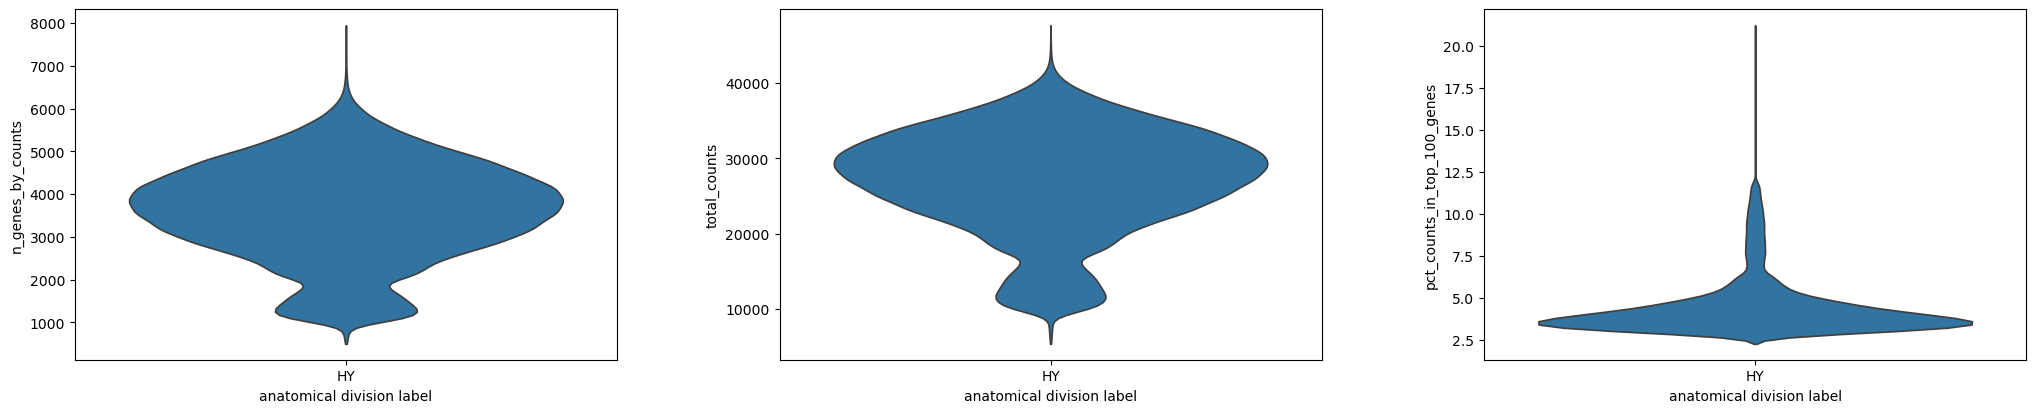

In [252]:
sc.pl.violin(
    adata_hyv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

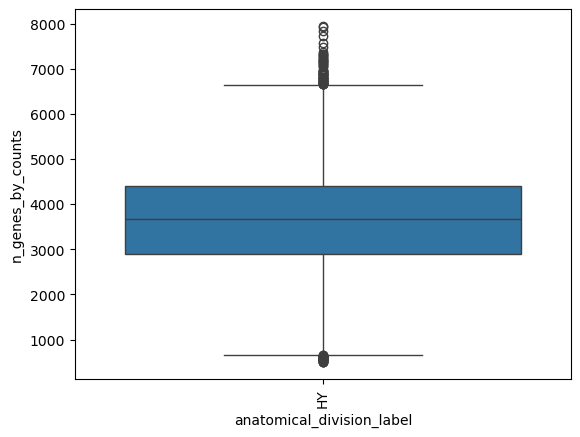

In [253]:
sns.boxplot(data=adata_hyv2.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

We will also plot the top 2000 higly variable genes of the v2 Hypothalamus

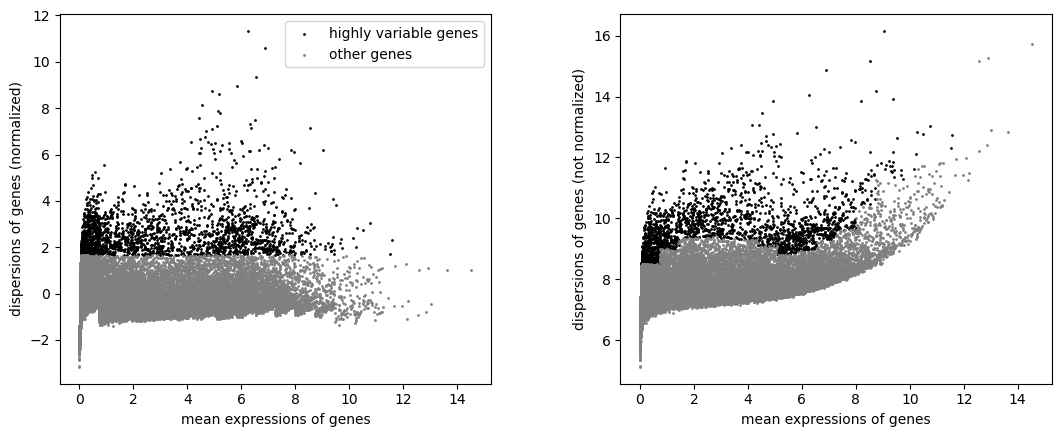

In [254]:
sc.pp.highly_variable_genes(adata_hyv2, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_hyv2)

A scatter plot of the v2 hypothalamus before we perform some sort of exploratory QC

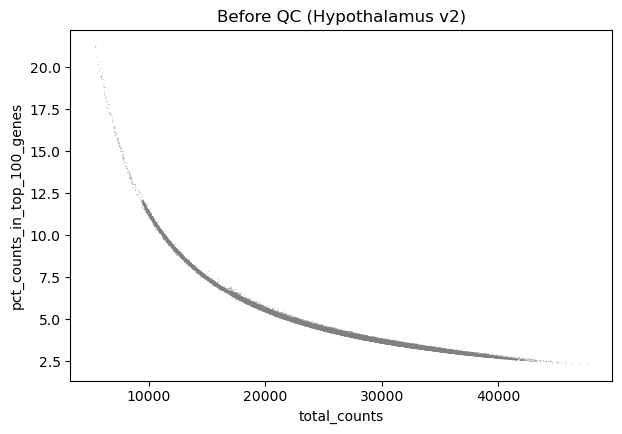

In [255]:
sc.pl.scatter(adata_hyv2, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Hypothalamus v2)")

In [256]:
# Filter out likely dead or damaged cells
adata_hyv2 = adata_hyv2[adata_hyv2.obs['n_genes_by_counts'] > 500, :]
adata_hyv2 = adata_hyv2[adata_hyv2.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_hyv2 = adata_hyv2[adata_hyv2.obs['n_genes_by_counts'] < 7000, :]

In [257]:
# Filter low information genes
sc.pp.filter_genes(adata_hyv2, min_cells=3)  # Keep genes expressed in at least 3 cells

A scatter plot of the v2 hypothalamus after we perform some sort of exploratory QC. We observe that there hardly any changes, an indication of the high quality of our data

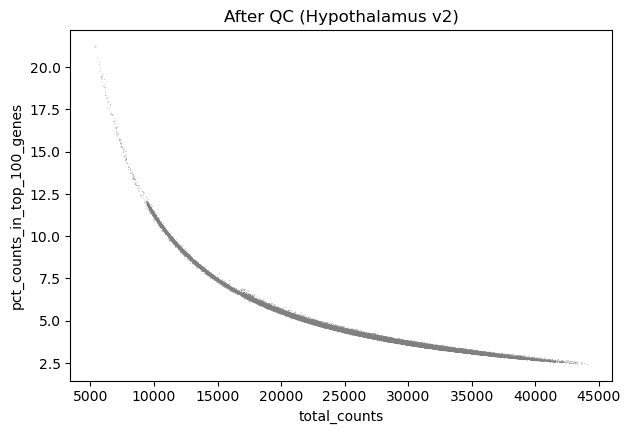

In [258]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv2, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v2)")

For the thalamus data of the v2 experiment, we will perform the same process as in the cells above

In [259]:
adata_thv2= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_thv2)

# print(adata.X)
print("\n\n-----Obs header-----\n\n",adata_thv2.obs.head())
print("\n\n-----Var header-----\n\n",adata_thv2.var.head())


AnnData object with n_obs × n_vars = 131212 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
CAGGTGCAGGCTAGCA-040_C01  CAGGTGCAGGCTAGCA  L8TX_180815_01_E08   
TGCGCAGGTTGCGCAC-045_C01  TGCGCAGGTTGCGCAC  L8TX_180829_01_C10   
CGATGTATCTTGCCGT-042_B01  CGATGTATCTTGCCGT  L8TX_180829_01_B09   
GACTAACGTCCTCTTG-040_B01  GACTAACGTCCTCTTG  L8TX_180815_01_D08   
GATCGTACAACTGCTA-040_B01  GATCGTACAACTGCTA  L8TX_180815_01_D08   

                         anatomical_division_label  
cell_label                                          
CAGGTGCAGGCTAGCA-040_C01                        TH  
TGCGCAGGTTGCGCAC-045_C01                        TH  
CGATGTATCTTGCCGT-042_B01                        TH  
GACTAACGTCCTCTTG-040_B01            

Once again, we get how many cells and genes we have. Notice that the number of cells increases while the number of genes remain the same, as to bo expected

In [260]:
print(type(adata_thv2.X))
print(adata_thv2.X.shape)
print(adata_thv2.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(131212, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


We move on to the QC for the thalamus v2 dataset

In [261]:
sc.pp.calculate_qc_metrics(adata_thv2, inplace=True)

In [ ]:
adata_thv2.obs['outlier_n_genes'] = find_outliers(adata_thv2.obs['n_genes_by_counts'])
adata_thv2.obs['outlier_total_counts'] = find_outliers(adata_thv2.obs['total_counts'])

# See how many outliers were found
print("Outliers in 'n_genes':", adata_thv2.obs['outlier_n_genes'].sum())
print("Outliers in 'total_counts':", adata_thv2.obs['outlier_total_counts'].sum())

# Per column
print(adata_thv2.obs.isna().sum())
print(adata_thv2.var.isna().sum())

# Total
print("Total NA in obs:", adata_thv2.obs.isna().sum().sum())
print("Total NA in var:", adata_thv2.var.isna().sum().sum())

dup_barcodes = adata_thv2.obs['cell_barcode'].duplicated()
print("Duplicate barcodes:", dup_barcodes.sum())

if(dup_barcodes.sum()!=0):
    # Remove if needed:
    print(f"Removing {dup_barcodes.sum()} duplicates")
    adata_thv2 = adata_thv2[~dup_barcodes, :]

# obs
obs_duplicates = adata_thv2.obs.duplicated()
print("Duplicate obs rows:", obs_duplicates.sum())

# var
var_duplicates = adata_thv2.var.duplicated()
print("Duplicate var rows:", var_duplicates.sum())

del dup_barcodes,obs_duplicates,var_duplicates
gc.collect()

Outliers in 'n_genes': 3
Outliers in 'total_counts': 0
cell_barcode                   0
library_label                  0
anatomical_division_label      0
n_genes_by_counts              0
log1p_n_genes_by_counts        0
total_counts                   0
log1p_total_counts             0
pct_counts_in_top_50_genes     0
pct_counts_in_top_100_genes    0
pct_counts_in_top_200_genes    0
pct_counts_in_top_500_genes    0
outlier_n_genes                0
outlier_total_counts           0
dtype: int64
gene_symbol              0
n_cells_by_counts        0
mean_counts              0
log1p_mean_counts        0
pct_dropout_by_counts    0
total_counts             0
log1p_total_counts       0
dtype: int64
Total NA in obs: 0
Total NA in var: 0
Duplicate barcodes: 10674
Removing 10674 duplicates
Duplicate obs rows: 0
Duplicate var rows: 7


We get a better visual understanding through violin plots and scatterplots

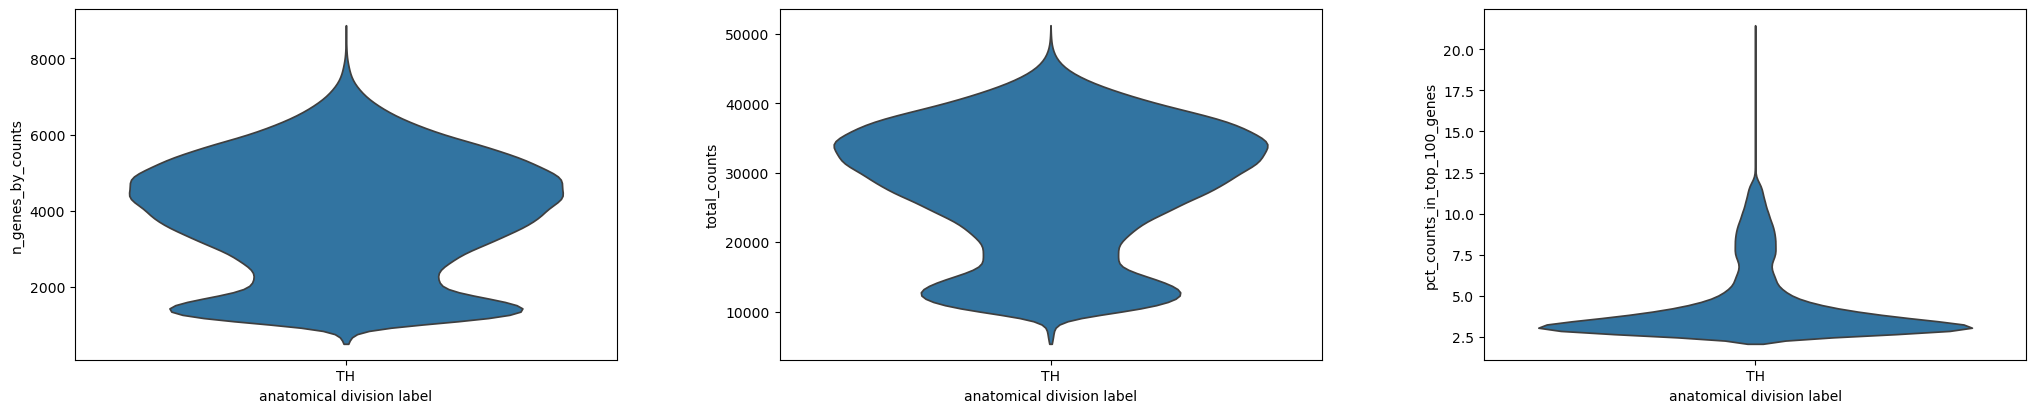

In [263]:
sc.pl.violin(
    adata_thv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

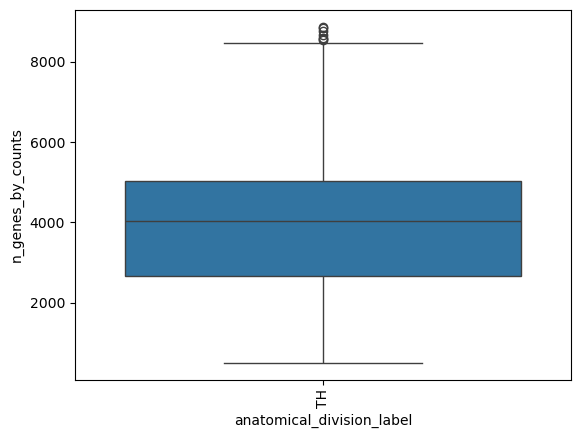

In [264]:
sns.boxplot(data=adata_thv2.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

The top 2000 highly variable genes for the thalamus v2 dataset

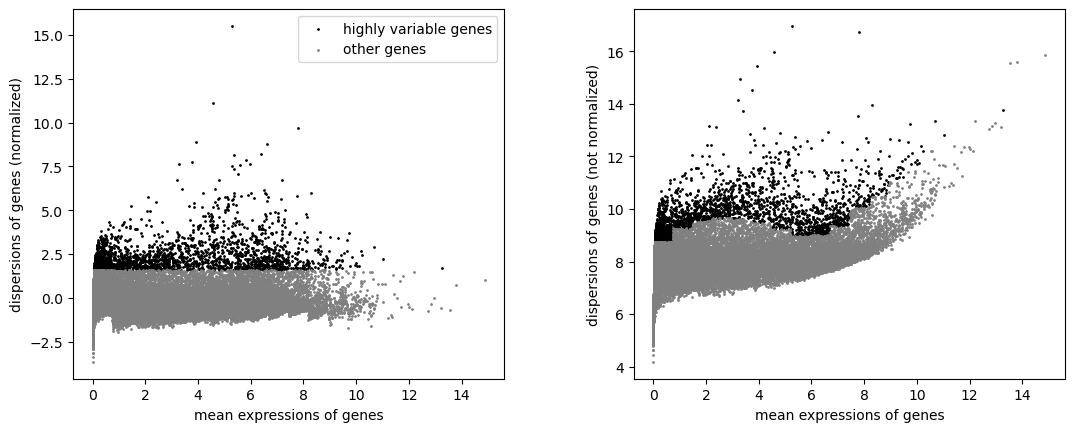

In [265]:
sc.pp.highly_variable_genes(adata_thv2, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_thv2)

A scatter plot of the thalamus v2 dataset before some exploratory QC

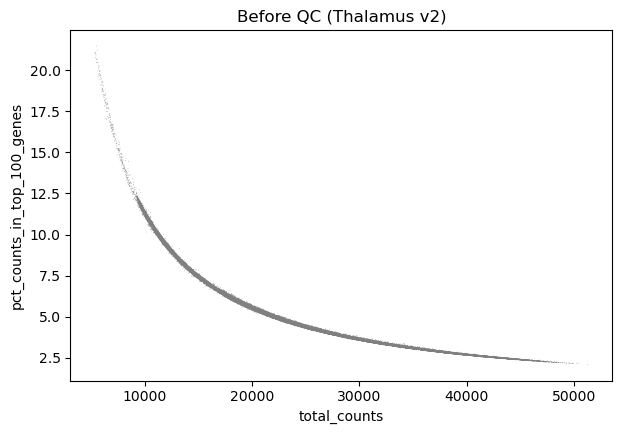

In [266]:
sc.pl.scatter(adata_thv2, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Thalamus v2)")

Some quality control

In [267]:
# Filter out likely dead or damaged cells
adata_thv2 = adata_thv2[adata_thv2.obs['n_genes_by_counts'] > 500, :]
adata_thv2 = adata_thv2[adata_thv2.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_thv2 = adata_thv2[adata_thv2.obs['n_genes_by_counts'] < 7000, :]

In [268]:
# Filter low information genes
sc.pp.filter_genes(adata_thv2, min_cells=3)  # Keep genes expressed in at least 3 cells

A scatter plot of the thalamus v2 dataset after some exploratory QC. Once again minimal changes, validating our knowledge about the high quality of the data

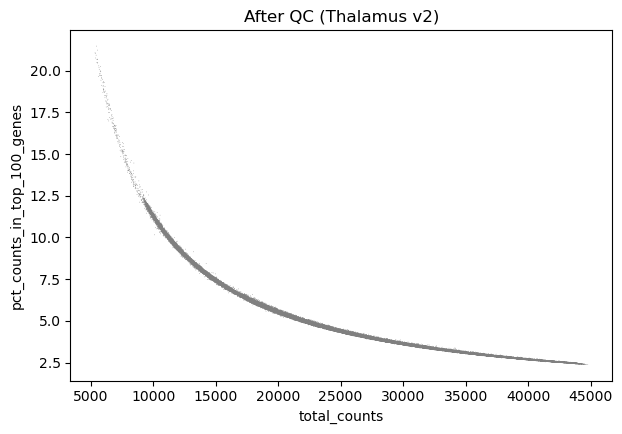

In [269]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_thv2, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Thalamus v2)")

In [270]:
# We join the two regions and plot
adata_thv2.obs['region']='Thalamus'
adata_hyv2.obs['region']='Hypothalamus'
adata_combinedv2=adata_thv2.concatenate(adata_hyv2)

In [ ]:
del adata_thv2,adata_hyv2
gc.collect()

We plot the two regions side by side for the v2 experiment, in order to get a better understanding of the situation. Already we can observe some of their differences through the violin plots. So, we reckon to be in the right track

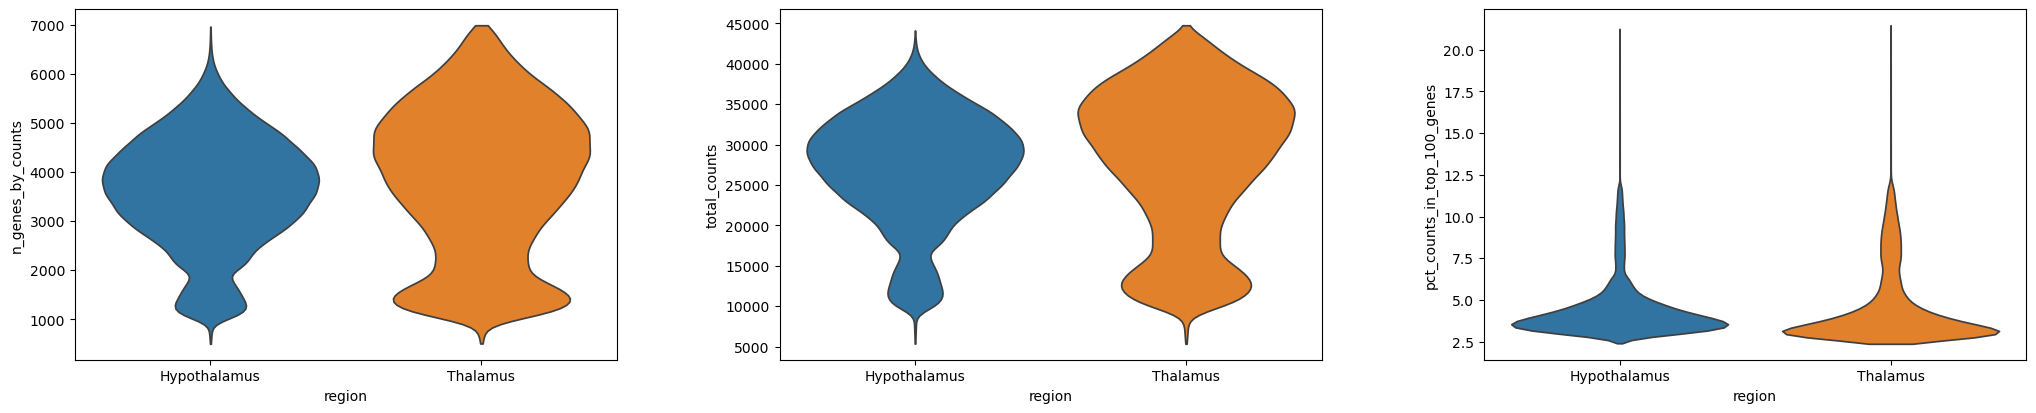

In [272]:
sc.pl.violin(
    adata_combinedv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='region',
    jitter=0.4,
    stripplot=False
)

In [ ]:
del adata_combinedv2
gc.collect()

The same visualization and exploration for the Hypothalamus v3 experiment dataset

In [274]:
adata_hyv3= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_hyv3)

print("\n\n-----Obs header-----\n\n",adata_hyv3.obs.head())
print("\n\n-----Var header-----\n\n",adata_hyv3.var.head())

AnnData object with n_obs × n_vars = 162869 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
TGAGGGACACCAAATC-392_A04  TGAGGGACACCAAATC  L8TX_201015_01_B03   
AACGGGAGTACGTGAG-469_A03  AACGGGAGTACGTGAG  L8TX_201217_01_F06   
GCTACAAAGACCATTC-326_D05  GCTACAAAGACCATTC  L8TX_200813_01_G10   
CCGAACGGTGCCTTCT-392_C04  CCGAACGGTGCCTTCT  L8TX_201015_01_E02   
CTTAGGAAGGACAAGA-577_A03  CTTAGGAAGGACAAGA  L8TX_210325_01_H07   

                         anatomical_division_label  
cell_label                                          
TGAGGGACACCAAATC-392_A04                        HY  
AACGGGAGTACGTGAG-469_A03                        HY  
GCTACAAAGACCATTC-326_D05                        HY  
CCGAACGGTGCCTTCT-392_C04            

Notice how the number of cells (entries) has increased compared to the v2 experiment but the number of genes (features) has remained the same. This indicates that the v3 experiment datasets may be prime candidates for our training sets.

In [275]:
print(type(adata_hyv3.X))
print(adata_hyv3.X.shape)
print(adata_hyv3.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(162869, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


In [276]:
sc.pp.calculate_qc_metrics(adata_hyv3, inplace=True)

In [ ]:
adata_hyv3.obs['outlier_n_genes'] = find_outliers(adata_hyv3.obs['n_genes_by_counts'])
adata_hyv3.obs['outlier_total_counts'] = find_outliers(adata_hyv3.obs['total_counts'])

# See how many outliers were found
print("Outliers in 'n_genes':", adata_hyv3.obs['outlier_n_genes'].sum())
print("Outliers in 'total_counts':", adata_hyv3.obs['outlier_total_counts'].sum())

# Per column
print(adata_hyv3.obs.isna().sum())
print(adata_hyv3.var.isna().sum())

# Total
print("Total NA in obs:", adata_hyv3.obs.isna().sum().sum())
print("Total NA in var:", adata_hyv3.var.isna().sum().sum())

dup_barcodes = adata_hyv3.obs['cell_barcode'].duplicated()
print("Duplicate barcodes:", dup_barcodes.sum())

if(dup_barcodes.sum()!=0):
    # Remove if needed:
    print(f"Removing {dup_barcodes.sum()} duplicates")
    adata_hyv3 = adata_hyv3[~dup_barcodes, :]

# obs
obs_duplicates = adata_hyv3.obs.duplicated()
print("Duplicate obs rows:", obs_duplicates.sum())

# var
var_duplicates = adata_hyv3.var.duplicated()
print("Duplicate var rows:", var_duplicates.sum())

del dup_barcodes,obs_duplicates,var_duplicates
gc.collect()

Outliers in 'n_genes': 0
Outliers in 'total_counts': 0
cell_barcode                   0
library_label                  0
anatomical_division_label      0
n_genes_by_counts              0
log1p_n_genes_by_counts        0
total_counts                   0
log1p_total_counts             0
pct_counts_in_top_50_genes     0
pct_counts_in_top_100_genes    0
pct_counts_in_top_200_genes    0
pct_counts_in_top_500_genes    0
outlier_n_genes                0
outlier_total_counts           0
dtype: int64
gene_symbol              0
n_cells_by_counts        0
mean_counts              0
log1p_mean_counts        0
pct_dropout_by_counts    0
total_counts             0
log1p_total_counts       0
dtype: int64
Total NA in obs: 0
Total NA in var: 0
Duplicate barcodes: 3511
Removing 3511 duplicates
Duplicate obs rows: 0
Duplicate var rows: 6


The same QC metrics' visualization, this time for the hypothalamus v3 dataset

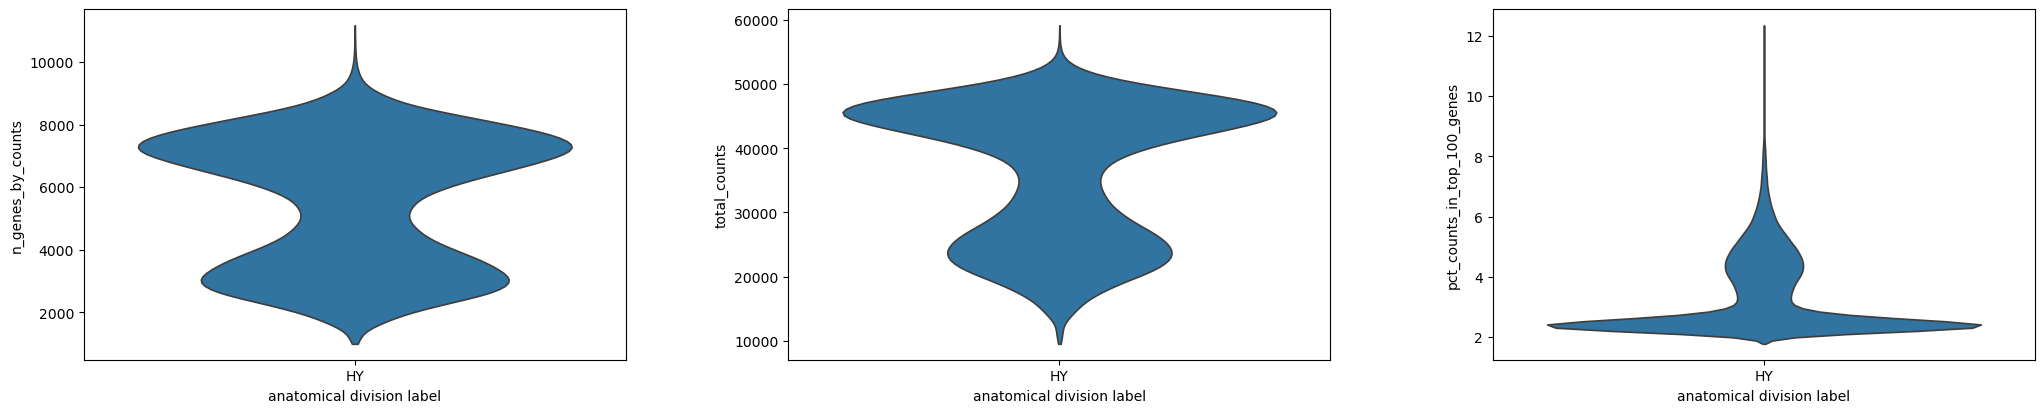

In [278]:
sc.pl.violin(
    adata_hyv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

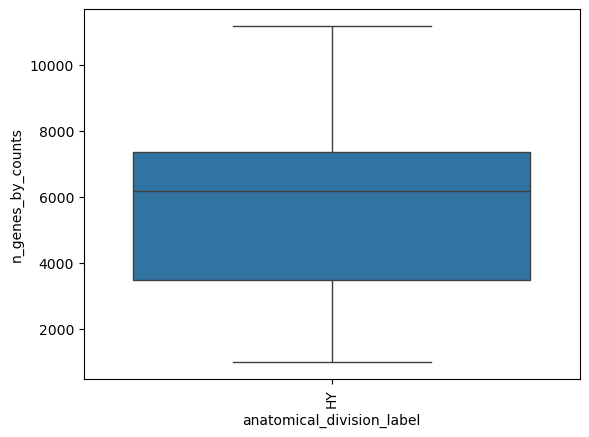

In [279]:
sns.boxplot(data=adata_hyv3.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

Once again the top 2000 highly variable genes for hypothamalus v3

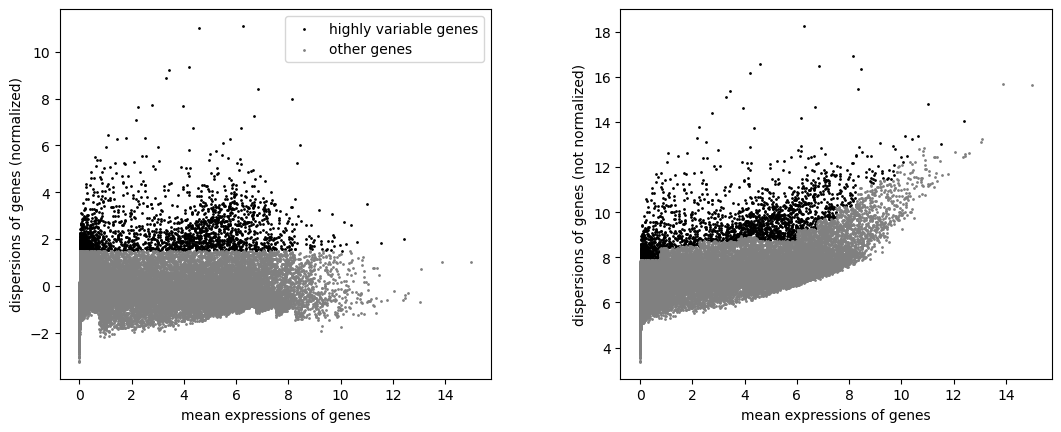

In [280]:
sc.pp.highly_variable_genes(adata_hyv3, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_hyv3)

A scatter plot of the hypothalamus v3 before our primitive QC

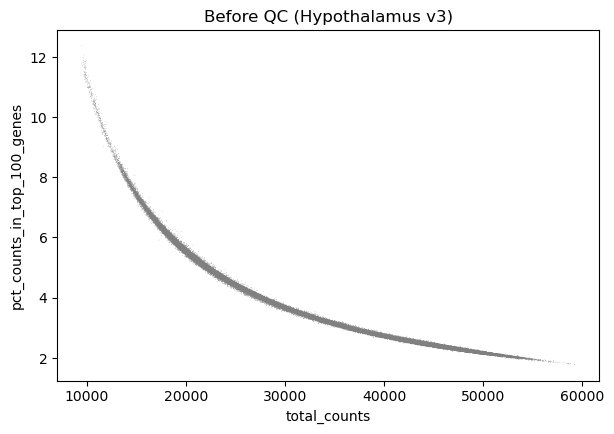

In [281]:
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Hypothalamus v3)")

Some quality control

In [282]:
# Filter out likely dead or damaged cells
adata_hyv3 = adata_hyv3[adata_hyv3.obs['n_genes_by_counts'] > 500, :]
adata_hyv3 = adata_hyv3[adata_hyv3.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_hyv3 = adata_hyv3[adata_hyv3.obs['n_genes_by_counts'] < 7000, :]

In [283]:
# Filter low information genes
sc.pp.filter_genes(adata_hyv3, min_cells=3)  # Keep genes expressed in at least 3 cells

And a scatter plot of the hypothalamus v3 after our primitive QC

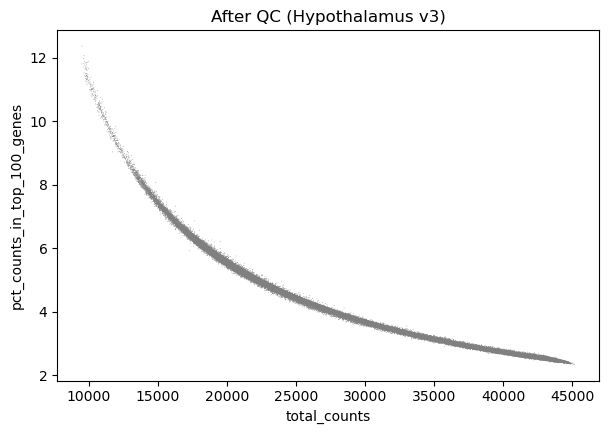

In [284]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v3)")

We will perform the same operations to the thalamus v3 dataset

In [285]:
adata_thv3= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-TH-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_thv3)

# print(adata.X)
print("\n\n-----Obs header-----\n\n",adata_thv3.obs.head())
print("\n\n-----Var header-----\n\n",adata_thv3.var.head())

AnnData object with n_obs × n_vars = 130856 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
AGAAGTATCATTACGG-290_B01  AGAAGTATCATTACGG  L8TX_200716_01_B06   
TTGACCCCAGGCCTGT-290_B01  TTGACCCCAGGCCTGT  L8TX_200716_01_B06   
AATGCCATCGCTAATG-290_B01  AATGCCATCGCTAATG  L8TX_200716_01_B06   
TGCGATAAGTCATGGG-290_B01  TGCGATAAGTCATGGG  L8TX_200716_01_B06   
CATCCCAAGATCCGAG-294_B05  CATCCCAAGATCCGAG  L8TX_200716_01_H06   

                         anatomical_division_label  
cell_label                                          
AGAAGTATCATTACGG-290_B01                        TH  
TTGACCCCAGGCCTGT-290_B01                        TH  
AATGCCATCGCTAATG-290_B01                        TH  
TGCGATAAGTCATGGG-290_B01            

We notice here that the thalamus v3 dataset does not have more entries that the v2 one, but still the total number of entries from these two regions is higher in the v3 experiment. So, we will stick to our plan and use the v3 set as the training set and the v2 set as the test set, thus ensuring that we will have no data leakage issues

In [286]:
print(type(adata_thv3.X))
print(adata_thv3.X.shape)
print(adata_thv3.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(130856, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


The operations that follow are the same as before

In [287]:
sc.pp.calculate_qc_metrics(adata_thv3, inplace=True)

In [ ]:
adata_thv3.obs['outlier_n_genes'] = find_outliers(adata_thv3.obs['n_genes_by_counts'])
adata_thv3.obs['outlier_total_counts'] = find_outliers(adata_thv3.obs['total_counts'])

# See how many outliers were found
print("Outliers in 'n_genes':", adata_thv3.obs['outlier_n_genes'].sum())
print("Outliers in 'total_counts':", adata_thv3.obs['outlier_total_counts'].sum())

# Per column
print(adata_thv3.obs.isna().sum())
print(adata_thv3.var.isna().sum())

# Total
print("Total NA in obs:", adata_thv3.obs.isna().sum().sum())
print("Total NA in var:", adata_thv3.var.isna().sum().sum())

dup_barcodes = adata_thv3.obs['cell_barcode'].duplicated()
print("Duplicate barcodes:", dup_barcodes.sum())

if(dup_barcodes.sum()!=0):
    # Remove if needed:
    print(f"Removing {dup_barcodes.sum()} duplicates")
    adata_thv3 = adata_thv3[~dup_barcodes, :]

# obs
obs_duplicates = adata_thv3.obs.duplicated()
print("Duplicate obs rows:", obs_duplicates.sum())

# var
var_duplicates = adata_thv3.var.duplicated()
print("Duplicate var rows:", var_duplicates.sum())

del dup_barcodes,obs_duplicates,var_duplicates
gc.collect()

Outliers in 'n_genes': 0
Outliers in 'total_counts': 0
cell_barcode                   0
library_label                  0
anatomical_division_label      0
n_genes_by_counts              0
log1p_n_genes_by_counts        0
total_counts                   0
log1p_total_counts             0
pct_counts_in_top_50_genes     0
pct_counts_in_top_100_genes    0
pct_counts_in_top_200_genes    0
pct_counts_in_top_500_genes    0
outlier_n_genes                0
outlier_total_counts           0
dtype: int64
gene_symbol              0
n_cells_by_counts        0
mean_counts              0
log1p_mean_counts        0
pct_dropout_by_counts    0
total_counts             0
log1p_total_counts       0
dtype: int64
Total NA in obs: 0
Total NA in var: 0
Duplicate barcodes: 2193
Removing 2193 duplicates
Duplicate obs rows: 0
Duplicate var rows: 5


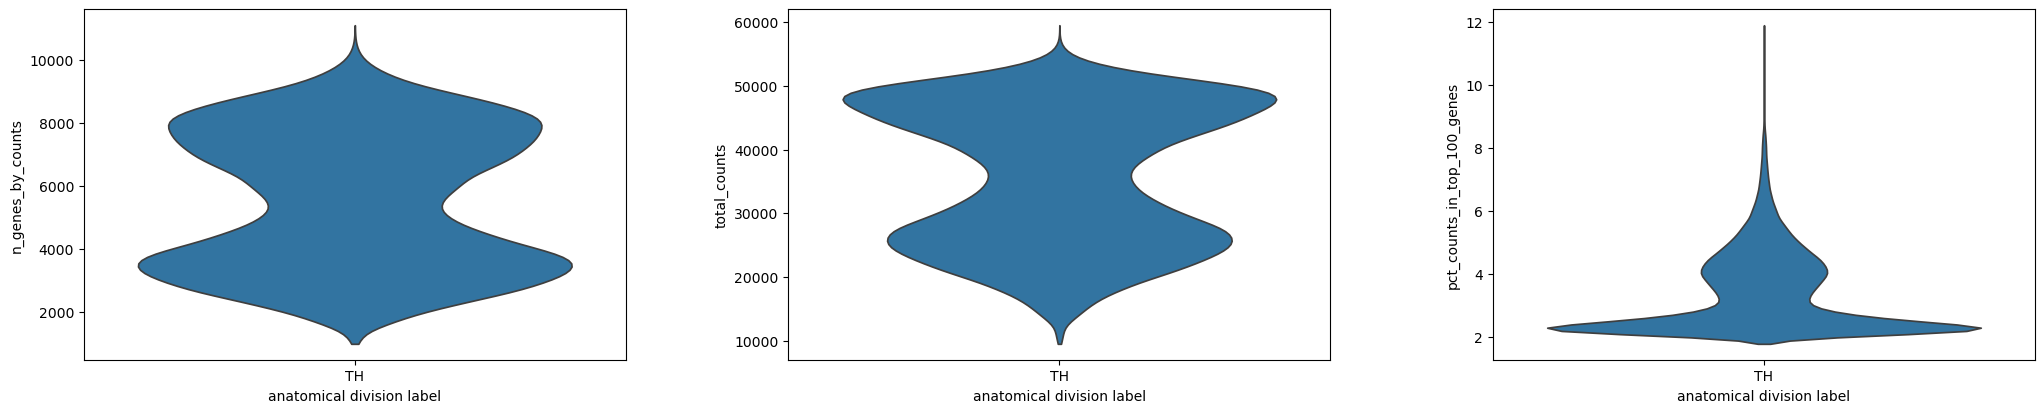

In [289]:
sc.pl.violin(
    adata_thv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

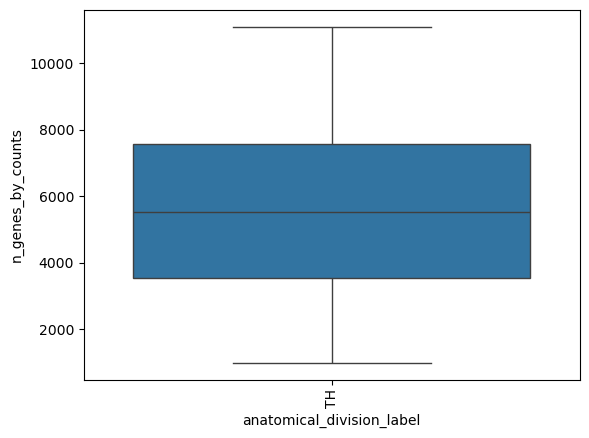

In [290]:
sns.boxplot(data=adata_thv3.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

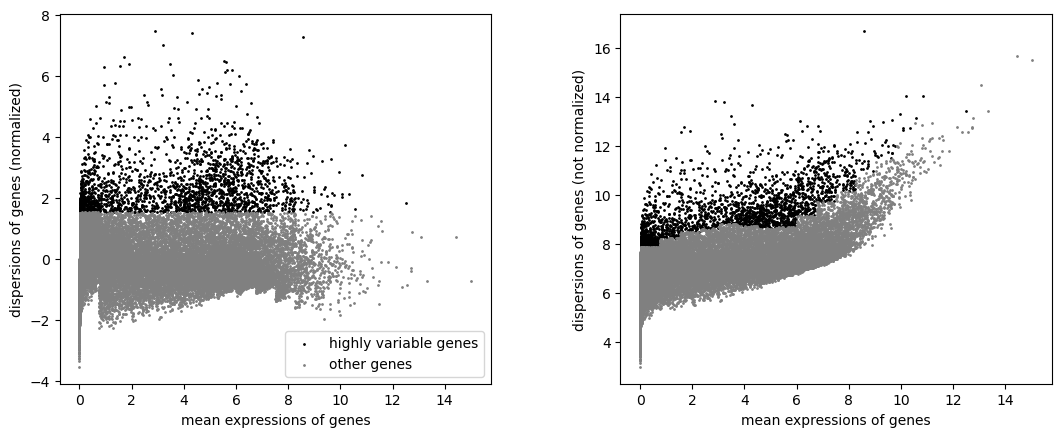

In [291]:
sc.pp.highly_variable_genes(adata_thv3, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_thv3)

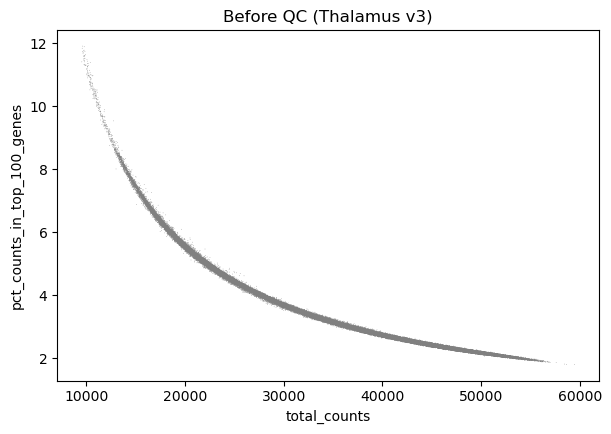

In [292]:
sc.pl.scatter(adata_thv3, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Thalamus v3)")

Some quality control

In [293]:
# Filter out likely dead or damaged cells
adata_thv3 = adata_thv3[adata_thv3.obs['n_genes_by_counts'] > 500, :]
adata_thv3 = adata_thv3[adata_thv3.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_thv3 = adata_thv3[adata_thv3.obs['n_genes_by_counts'] < 7000, :]

In [294]:
# Filter low information genes
sc.pp.filter_genes(adata_thv3, min_cells=3)  # Keep genes expressed in at least 3 cells

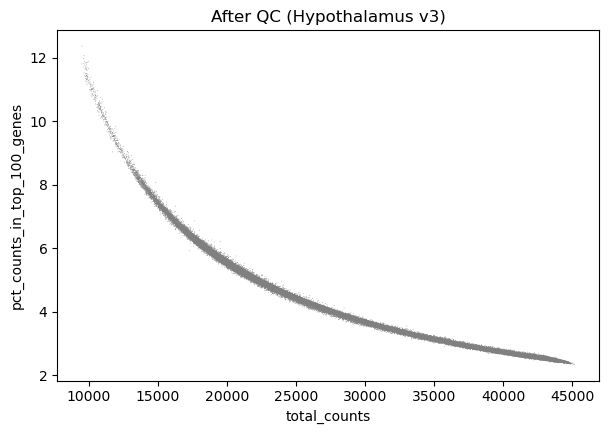

In [295]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v3)")

In [296]:
# We join the two regions and plot
adata_thv3.obs['region']='Thalamus'
adata_hyv3.obs['region']='Hypothalamus'
adata_combinedv3=adata_thv3.concatenate(adata_hyv3)

In [ ]:
del adata_thv3,adata_hyv3
gc.collect()

We plot the two regions from the v3 experiment side by side. We once again notice that there are some distinct differences, hinting that we are on the right track

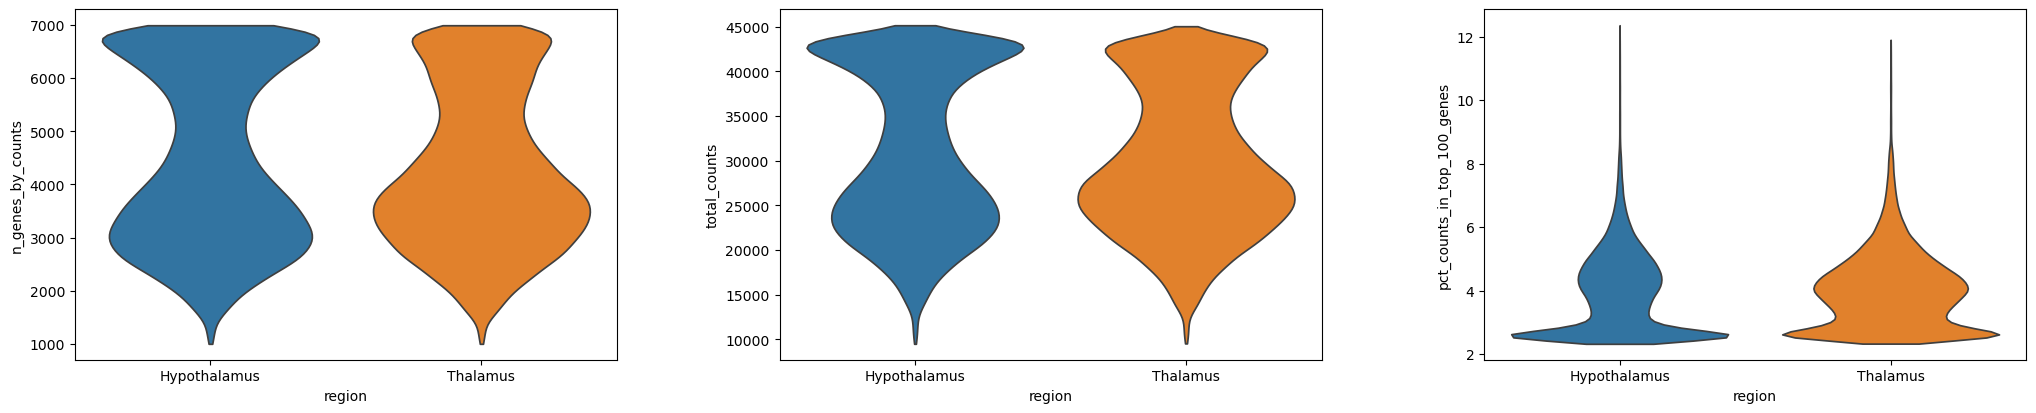

In [298]:
sc.pl.violin(
    adata_combinedv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='region',
    jitter=0.4,
    stripplot=False
)

In [ ]:
del adata_combinedv3
gc.collect()

We get a basic idea of what the metadata file consists of

In [300]:
metadf=pd.read_csv("../data/abc_atlas/metadata/WMB-10X/20230630/region_of_interest_metadata.csv")
metadf.head()

,acronym,label,name,order,color_hex_triplet
0,MO-FRP,WMB-MO-FRP,Somatomotor - Frontal pole,0,#3DCC7C
1,MOp,WMB-MOp,Primary motor area,1,#179968
2,SS-GU-VISC,WMB-SS-GU-VISC,Somatosensory/gustatory/visceral areas,2,#2E8599
3,SSp,WMB-SSp,Primary somatosensory area,3,#5CCCCC
4,AUD,WMB-AUD,Auditory areas,4,#455A99


In [ ]:
del metadf
gc.collect()